In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import seaborn as sns
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import sklearn

for p in [np, pd, sklearn]:
    print (p.__name__, p.__version__)

numpy 1.20.1
pandas 1.2.2
sklearn 0.24.0


In [7]:
from itertools import product
from modules import downcast_dtypes, get_split_points, get_train_val, \
                    add_shop_last_stat, add_item_last_stat, fit_and_eval, fill_with_0_target, get_new_val

In [8]:
def add_category_last_stat(data):
    """
    add last month sales by category_id
    """
    grouped = data.groupby(['date_block_num', 'item_category_id']).target.sum()
    grouped = grouped.reset_index()
    grouped['date_block_num'] += 1
    grouped.rename(columns={'target': 'prev_category_sales'}, inplace=True)
    return pd.merge(data, grouped,how='left',on=['date_block_num', 'item_category_id'])


def add_cum_mean_target(data, by):
    """
    cumulative mean gouped by different categorical features
    """
    cumsum = data.groupby(by).target.cumsum() - data['target']
    cumcnt = data.groupby(by).target.cumcount()
    data[by[:-2] + 'target_enc'] = cumsum / cumcnt
    data[by[:-2] + 'target_enc'].fillna(0.3343, inplace=True)
    return data

### Final part is at the end of notebook.
In the beginning there is some EDA, experiments and thoughts on constructing dataset.

In [4]:
all_data = fill_with_0_target(downcast_dtypes(pd.read_csv('sales_train.csv')))

In [5]:
sales = pd.read_csv('sales_train.csv')

(-2.0, 5000.0)

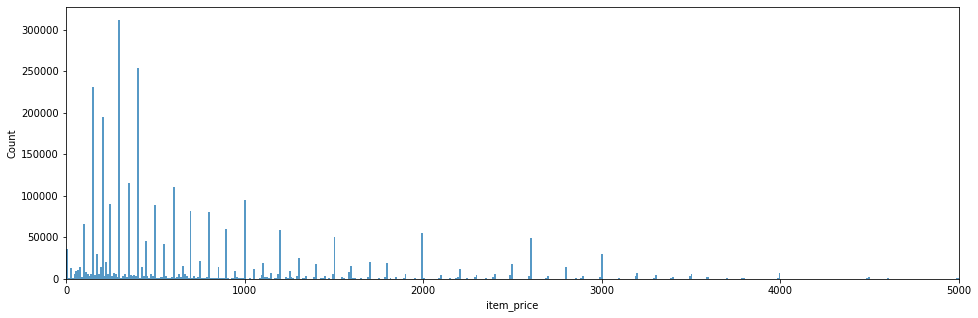

In [6]:
plt.figure(figsize=(16,5))
sns.histplot(sales['item_price'])
plt.xlim([-2, 5000])

The most of item prices are below 5000

In [11]:
all_data = fill_with_0_target(downcast_dtypes(sales.loc[sales['item_price'] < 6000]))

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
np.percentile(sales['item_price'], 99)

5999.0

The 99th percentile of item_price is 5999, that's why I chose it to drop outliers.

In [12]:
print(sales['item_price'].min(), sales['item_price'].max())

-1.0 307980.0


In [14]:
all_data['target'] = all_data['target'].clip(0., 20.)
#calc stat of item and shop sales of last month
all_data = add_item_last_stat(all_data)
all_data = add_shop_last_stat(all_data)

all_data['is_new_item'] = all_data.prev_item_sales.isna().astype(int)
all_data['month'] = all_data['date_block_num'] % 12

In [15]:
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')

In [16]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
all_data

,shop_id,item_id,date_block_num,target,prev_item_sales,prev_shop_sales,is_new_item,month
0,0,19,0,0.0,NaN,NaN,1,0
1,0,27,0,0.0,NaN,NaN,1,0
2,0,28,0,0.0,NaN,NaN,1,0
3,0,29,0,0.0,NaN,NaN,1,0
4,0,32,0,6.0,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...
10817196,59,22162,33,0.0,7.0,904.0,0,9
10817197,59,22163,33,0.0,20.0,904.0,0,9
10817198,59,22164,33,0.0,9.0,904.0,0,9
10817199,59,22166,33,0.0,5.0,904.0,0,9


In [18]:
# add item_category to all_data table
all_data = pd.merge(all_data, items, how='left', on='item_id').fillna(0.).drop(columns=['item_name'])

In [19]:
all_data.head()

,shop_id,item_id,date_block_num,target,prev_item_sales,prev_shop_sales,is_new_item,month,item_category_id
0,0,19,0,0.0,0.0,0.0,1,0,40
1,0,27,0,0.0,0.0,0.0,1,0,19
2,0,28,0,0.0,0.0,0.0,1,0,30
3,0,29,0,0.0,0.0,0.0,1,0,23
4,0,32,0,6.0,0.0,0.0,1,0,40


In [20]:
#drop date_block_num=0 and date_block_num=34 (test)
train_exp_on_prev = all_data.fillna(0.).loc[(all_data['date_block_num'] > 0) & (all_data['date_block_num'] < 34)]

In [25]:
print('new column = item_category_id')
model =  fit_and_eval(train_exp_on_prev, algo='cbr',early_stopping_rounds=5)

new column = item_category_id
Model:  cbr
feat importancies:  [47.07856969 26.40333576  3.39379632  7.84963197 15.27466626]
rmse on val:  [0.9091792571116921, 0.8345350922381436, 0.9074456160686453, 1.0105273426450032, 0.9698690269683631]
best iterations:  [52, 29, 48, 29, 39]


In [37]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse


#redefined fit_and_eval with new name fit_and_eval2 in order to test how cat_features attribute works at catboost
def fit_and_eval2(data, algo='rfr', early_stopping_rounds=5):
    train_split_points, val_split_points = get_split_points(data)

    val_results = []
    best_iterations = []
    for train, val in get_train_val(data, train_split_points, val_split_points):
        extra_items = set(val.item_id) - set(train.item_id)
        extra_idces = val.loc[val['item_id'].isin(extra_items)].index - val.index.min()
        val = get_new_val(val, extra_items, extra_idces).reset_index(drop=True)
#         X_train = np.array(train.drop(['date_block_num', 'target', 'item_id', 'shop_id'], axis=1))
        X_train = train.drop(['date_block_num', 'target', 'item_id', 'shop_id'], axis=1)
#         X_val = np.array(val.drop(['date_block_num', 'target', 'item_id', 'shop_id'], axis=1))
        X_val = val.drop(['date_block_num', 'target', 'item_id', 'shop_id'], axis=1)
        y_train, y_val = np.array(train['target']), np.array(val['target'])
        if algo == 'rfr':
            model = RandomForestRegressor(n_estimators=64, n_jobs=-1)
            model.fit(X_train, y_train)
        else:
            model = CatBoostRegressor(cat_features=['item_category_id'])
            model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=early_stopping_rounds, silent=True)
        preds = model.predict(X_val)
        extra_idces = val.loc[val['item_id'].isin(extra_items)].index - val.index.min()
        preds[extra_idces] += 0.3
        val_results.append(mse(preds, y_val, squared=False))
        best_iterations.append(model.best_iteration_)
    print('Model: ', algo)
    print('feat importancies: ', model.feature_importances_)
    print('rmse on val: ', val_results)
    print('best iterations: ', best_iterations)
    return model

In [38]:
print('new column = item_category_id added as cat_feature in catboost')
model =  fit_and_eval2(train_exp_on_prev, algo='cbr',early_stopping_rounds=5)

new column = item_category_id added as cat_feature in catboost
Model:  cbr
feat importancies:  [52.04992839 29.04140047  2.81879832  6.25987099  9.83000183]
rmse on val:  [0.9296904121213081, 0.8382860983250087, 0.9046615678588986, 0.9980526026212501, 0.9740851942965365]
best iterations:  [29, 29, 56, 26, 20]


In [40]:
all_data = add_cum_mean_target(all_data, by='item_category_id')

In [43]:
train_exp_on_prev = all_data.fillna(0.).loc[(all_data['date_block_num'] > 0) & (all_data['date_block_num'] < 34)]

#### Different experiments

In [44]:
print('new column = item_category_id mean encoded')
model =  fit_and_eval(train_exp_on_prev, algo='cbr',early_stopping_rounds=5)

new column = item_category_id mean encoded
Model:  cbr
feat importancies:  [48.91645442 25.83866754  3.48724535  6.86011238  6.58152827  8.31599204]
rmse on val:  [0.9054465830732805, 0.8321833546183878, 0.8917379651935874, 0.9932953227796706, 0.9606892632265039]
best iterations:  [75, 45, 49, 30, 31]


In [47]:
print('new column = item_category_id mean encoded without item_category_id')
model =  fit_and_eval(train_exp_on_prev.drop(columns=['item_category_id']), algo='cbr',early_stopping_rounds=5)

new column = item_category_id mean encoded without item_category_id
Model:  cbr
feat importancies:  [51.72796547 29.77827201  2.55237147  6.59788753  9.34350352]
rmse on val:  [0.9144906874339123, 0.8501166086849891, 0.8975475324127261, 1.0146009312085198, 0.976543611956666]
best iterations:  [72, 27, 50, 21, 19]


In [49]:
all_data = add_category_last_stat(all_data)

In [52]:
train_exp_on_prev = all_data.fillna(0.).loc[(all_data['date_block_num'] > 0) & (all_data['date_block_num'] < 34)]
print('new column = item_category_id mean encoded & prev category sales')
model =  fit_and_eval(train_exp_on_prev, algo='cbr',early_stopping_rounds=5)

new column = item_category_id mean encoded & prev category sales
Model:  cbr
feat importancies:  [45.64972205 26.21136813  3.70736177  7.56895319  6.019342    8.70916487
  2.13408799]
rmse on val:  [0.9108064611179884, 0.8368991645455478, 0.8898670916186954, 1.0032162524537196, 0.9591540692051995]
best iterations:  [64, 46, 34, 31, 40]


In [53]:
print('new column = item_category_id mean encoded & prev category sales & early_stopping_rounds = 30')
model =  fit_and_eval(train_exp_on_prev, algo='cbr',early_stopping_rounds=30)

new column = item_category_id mean encoded & prev category sales & early_stopping_rounds = 30
Model:  cbr
feat importancies:  [45.64972205 26.21136813  3.70736177  7.56895319  6.019342    8.70916487
  2.13408799]
rmse on val:  [0.8895812454231121, 0.837829463313929, 0.8735236083872027, 0.9943844702484855, 0.9660495646215803]
best iterations:  [171, 78, 423, 31, 40]


#### Different experiments finished

In [34]:
train_exp_on_prev

,shop_id,item_id,date_block_num,target,prev_item_sales,prev_shop_sales,is_new_item,month,item_category_id
362565,0,12,1,0.0,0.0,5366.0,1,1,55
362566,0,27,1,0.0,7.0,5366.0,0,1,19
362567,0,28,1,0.0,8.0,5366.0,0,1,30
362568,0,30,1,20.0,0.0,5366.0,1,1,40
362569,0,31,1,11.0,0.0,5366.0,1,1,37
...,...,...,...,...,...,...,...,...,...
10817196,59,22162,33,0.0,7.0,904.0,0,9,40
10817197,59,22163,33,0.0,20.0,904.0,0,9,40
10817198,59,22164,33,0.0,9.0,904.0,0,9,37
10817199,59,22166,33,0.0,5.0,904.0,0,9,54


## Create final set of features, learn and submit

#### Features:
1. encoded city of shops
2. category_id
3. prev month sales of item, shop, category
4. Mean Target encoded category_id

#### Dataset:
1. filled with zero target
2. target clipped by 20
3. nans replaced with 0.
4. created 3 folds: train (date_block_num < 33), val(date_block_num = 33), test (date_block_num = 34)
5. stopped fitting when loss started to grow on val split
6. for extra items predictions I added 0.3 because predictions on extra items were lower statistically

#### Model
Tried Random Forest but it is slower and gives lower quality than catboost.
For catboost tried different early_stopping_rounds, depth, grow_policy. I found that early_stopping_rounds=5, depth=16 with default grow_policy works best.
I could do more but I achived sufficient quality to be accepted by coursera when I was on week 2 or 3 and I stopped continue to work on that problem.

In [2]:
def add_cum_mean_target_only_pos(data, by):
    cumsum = all_data.groupby(by).target.cumsum() - all_data['target']
    cumcnt = all_data.loc[all_data['target'] > 0].groupby(by).target.cumcount()
    data[by[:-2] + 'target_enc'] = cumsum / cumcnt
    data[by[:-2] + 'target_enc'].fillna(0.3343, inplace=True)
    return data

In [9]:
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder


def create_feats(data):
    data = add_item_last_stat(data)
    data = add_shop_last_stat(data)
    data = add_category_last_stat(data)
    data = add_cum_mean_target(data, by='item_category_id')
    data['is_new_item'] = data.prev_item_sales.isna().astype(int)
    return data
    


def make_test_pred_and_save():
    test = pd.read_csv('test.csv')
    items = pd.read_csv('items.csv')
    shops = pd.read_csv('shops.csv')
    shops['city'] = shops['shop_name'].str.split(" ").map(lambda x: x[0])
    shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
    test["date_block_num"] = 34
    test.drop('ID', axis=1, inplace=True)
    all_data = fill_with_0_target(downcast_dtypes(pd.read_csv('sales_train.csv').loc[pd.read_csv('sales_train.csv')['item_price'] < 100000]))
    print('all_data initialized')
    all_data = pd.concat([all_data, test])
    all_data['target'] = all_data['target'].clip(0., 20.)
    all_data = pd.merge(all_data, items, how='left', on='item_id').fillna(0.).drop(columns=['item_name'])
    all_data = pd.merge(all_data, shops, how='left', on='shop_id').fillna(0.).drop(columns=['shop_name', 'city'])
    all_data = create_feats(all_data)
    all_data = all_data.fillna(0.)
    print('feats are constructed')
    train_exp_on_prev = all_data.fillna(0.).loc[(all_data['date_block_num'] > 0) & (all_data['date_block_num'] < 33)]
    test = all_data.fillna(0.).loc[all_data['date_block_num'] == 34]
    extra_items = set(test.item_id) - set(train_exp_on_prev.item_id)
    extra_idces = test.loc[test['item_id'].isin(extra_items)].index - test.index.min()
    X_test = np.array(test.drop(['date_block_num', 'target', 'item_id', 'shop_id'], axis=1))
    train = train_exp_on_prev
    val = all_data.loc[all_data['date_block_num'] == 33]
    extra_items_val = set(val.item_id) - set(train.item_id)
    extra_idces_val = val.loc[val['item_id'].isin(extra_items_val)].index - val.index.min()
    val = get_new_val(val, extra_items_val, extra_idces_val).reset_index(drop=True)
    X_train = np.array(train.drop(['date_block_num', 'target', 'item_id', 'shop_id'], axis=1))
    X_val = np.array(val.drop(['date_block_num', 'target', 'item_id', 'shop_id'], axis=1))
    y_train, y_val = np.array(train['target']), np.array(val['target'])
    print('learning started')
    model = CatBoostRegressor(depth=16)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=5, silent=True)
    print(mse(np.clip(model.predict(X_val), 0, 20), y_val, squared=False))

    preds = model.predict(X_test)
    preds[extra_idces] += 0.3
    preds = np.clip(preds, 0, 20)
    test_pred = pd.read_csv('test.csv')
    submission = test_pred.loc[:,['ID']]
    submission['item_cnt_month'] = preds
    submission.to_csv('submission.csv', index=False)
    return model

#### Some Experiments

In [64]:
make_test_pred_and_save()

all_data initialized
feats are constructed
learning started
0.9856962303222733


In [11]:
make_test_pred_and_save()

all_data initialized
feats are constructed
learning started
0.9620667865839291


In [15]:
model = make_test_pred_and_save()

all_data initialized
feats are constructed
learning started
0.9670867593769187


#### Experiments finished

In [29]:
model = make_test_pred_and_save()

all_data initialized
feats are constructed
learning started
0.9216629311754139


In [30]:
model.save_model('catboost_final')

In [33]:
def restore_model():
    from_file = CatBoostRegressor()
    from_file.load_model("catboost_final")
    return from_file

restored_model = restore_model()

In [16]:
print('feat importancies: ', model.feature_importances_)

feat importancies:  [ 7.33987337 49.774018   23.58131256  6.09756225  9.43243823  3.7747956 ]


Quality achieved on public leaderbord 0.994984, On private 0.994627.
That means that algo didnt overfit